## Import Required Packages

In [215]:
# Install required packages
!pip install hazm
!pip install clean-text[gpl]

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [216]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import hazm
from cleantext import clean
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import os
import re
import json
import copy
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features
import tensorflow as tf

## Load the Dataset

In [217]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
data = pd.read_csv('/kaggle/input/taghchemain/taghche.csv')

# Select only the 'comment' and 'rate' columns for further analysis
data = data[['comment', 'rate']]

# Display the first 10 rows of the DataFrame to get an overview of the data
data.head(10)

,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0.0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5.0
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5.0
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2.0
4,کتاب خوبی است,3.0
5,راستش خیلی خوشم نیومد ازش!,3.0
6,کتابی شیوا و بینظیر یکی دیگر از شاهکار های اقا...,5.0
7,"هر هشت تای این داستانها توی کتاب ""بهترین داستا...",3.0
8,سلام چرا این نمونه نداره که بدونیم کدوم داستان...,1.0
9,دارم ب این جمع بندی میرسم ک مارکز هیچ جوره نوی...,2.0


### Fixing Conflicts

As you might be realized, the dataset has some structural problems, as shown below.

![alt text](https://res.cloudinary.com/m3hrdadfi/image/upload/v1596398432/kaggle/data-structure-flaws_xoqprk.png)

For simplicity, I fix this problem by removing rows with the `rate` value of `None`. Furthermore, the dataset contains duplicated rows and missing values in the comment section.

In [218]:
# Print the general information about the DataFrame
print('data information')
print(data.info(), '\n')

# Print the statistics of missing values in the DataFrame
print('missing values stats')
print(data.isnull().sum(), '\n')

# Print the first 5 rows where the 'rate' column has missing values
print('some missing values')
print(data[data['rate'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69829 entries, 0 to 69828
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  69808 non-null  object 
 1   rate     69790 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB
None 

missing values stats
comment    21
rate       39
dtype: int64 

some missing values
                                                comment  rate
5343                           مسأله حجاب و محمد رضاشاه   NaN
7455  سوژه ای با این اهمیت و منحصربه فرد بودن، تجربه...   NaN
7456                                                NaN   NaN
7457                                                NaN   NaN
7680  نویسنده رویکرد قابل تامل و پدیدارشناسانه ای به...   NaN 



In [219]:
# Handle conflicts in the dataset structure
# For simplicity, remove invalid data combinations

# Replace ratings that are 6 or higher with None
# This assumes that valid ratings should be between 0 and 5
data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

# Drop rows where the 'rate' column has missing values
data = data.dropna(subset=['rate'])

# Drop rows where the 'comment' column has missing values
data = data.dropna(subset=['comment'])

# Remove duplicate comments, keeping only the first occurrence
data = data.drop_duplicates(subset=['comment'], keep='first')

# Reset the index of the DataFrame
data = data.reset_index(drop=True)

# Print the general information about the DataFrame
print('data information')
print(data.info(), '\n')

# Print the statistics of missing values in the DataFrame
print('missing values stats')
print(data.isnull().sum(), '\n')

# Print the first 5 rows where the 'rate' column has missing values
print('some missing values')
print(data[data['rate'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64157 entries, 0 to 64156
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  64157 non-null  object 
 1   rate     64157 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1002.6+ KB
None 

missing values stats
comment    0
rate       0
dtype: int64 

some missing values
Empty DataFrame
Columns: [comment, rate]
Index: [] 



## Preprocessing

The comments have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step. On the other hand, we suppose that the minimum word combination for having a meaningful phrase for our learning process is 1.

In [220]:
# Calculate the length of comments based on the number of words
# This uses hazm's word_tokenize function to split comments into words and then counts the number of words
data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# Determine the minimum and maximum comment lengths
# This provides insights into the range of comment lengths in the dataset
min_max_len = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()

# Print the minimum and maximum comment lengths
# This helps understand the variation in comment lengths
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 2691


In [221]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    """
    Calculate the percentage of comments with lengths greater than 'greater_than' and less than or equal to 'less_than'.

    Parameters:
    data (DataFrame): The DataFrame containing the data.
    less_than (float): The upper bound for the comment length.
    greater_than (float): The lower bound for the comment length.
    col (str): The column name that contains the comment lengths.

    Returns:
    None
    """
    # Extract the lengths of the comments from the specified column
    data_length = data[col].values

    # Count the number of comments that have a length greater than 'greater_than' and less than or equal to 'less_than'
    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    # Calculate the percentage of such comments relative to the total number of comments
    data_glt_rate = (data_glt / len(data_length)) * 100

    # Print the result
    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

# Call the function with specific bounds
data_gl_than(data, 256, 0)

Texts with word length of greater than 0 and less than 256 includes 98.82% of the whole!


In [222]:
# Define minimum and maximum limits for comment length
minlim, maxlim = 0, 256

# Remove comments with a length of fewer than three words or more than 256 words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)

# Drop rows where the 'comment_len_by_words' column has missing values
data = data.dropna(subset=['comment_len_by_words'])

# Reset the index of the DataFrame
data = data.reset_index(drop=True)

In [223]:
# This initializes an empty figure to which we will add traces
fig = go.Figure()

# Add a histogram trace to the figure
# The x-axis data is taken from the 'comment_len_by_words' column
fig.add_trace(go.Histogram(
    x=data['comment_len_by_words'],
    marker=dict(
        color='rgb(0, 123, 255)',  # Set bar color to a blue shade
        line=dict(
            color='rgb(8, 48, 107)',  # Set bar border color to a darker blue
            width=1.5,  # Set the width of the bar borders
        ),
    ),
    opacity=0.75,  # Set the opacity of the bars for a slight transparency effect
))

# Update the layout of the figure
# This includes setting titles for the plot and axes, and customizing the appearance
fig.update_layout(
    title=dict(
        text='Distribution of Word Counts Within Comments',  # Set the title of the plot
        font=dict(size=24),  # Set the font size of the title
        x=0.5,  # Center the title on the plot
    ),
    xaxis=dict(
        title=dict(
            text='Word Count',  # Set the x-axis title
            font=dict(size=18),  # Set the font size of the x-axis title
        ),
        tickfont=dict(size=14),  # Set the font size of the x-axis tick labels
    ),
    yaxis=dict(
        title=dict(
            text='Frequency',  # Set the y-axis title
            font=dict(size=18),  # Set the font size of the y-axis title
        ),
        tickfont=dict(size=14),  # Set the font size of the y-axis tick labels
    ),
    bargap=0.2,  # Set the gap between individual bars
    bargroupgap=0.2,  # Set the gap between groups of bars
    template='plotly_white'  # Use the 'plotly_white' template for a cleaner look
)

# Show the figure
fig.show()

In [224]:
# Extract unique 'rate' values from the 'data' DataFrame, sort them, and convert them into a list
unique_rates = list(sorted(data['rate'].unique()))

# Print the number of unique rates and the list of unique rates
print(f'We have {len(unique_rates)} unique rates: {unique_rates}')

We have 6 unique rates: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


In [225]:
# Create a figure for the plot
fig = go.Figure()

# Group the data by 'rate' and count the occurrences of each rate
groupby_rate = data.groupby('rate')['rate'].count()

# Add a bar trace to the figure
fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),  # Set the x-axis data to the sorted unique rates
    y=groupby_rate.tolist(),  # Set the y-axis data to the frequency counts of each rate
    text=groupby_rate.tolist(),  # Display the frequency counts as text on the bars
    textposition='auto',  # Automatically position the text within the bars
    marker=dict(
        color='rgb(255, 123, 0)',  # Set bar color to an orange shade
        line=dict(
            color='rgb(107, 48, 8)',  # Set bar border color to a darker orange/brown
            width=1.5,  # Set the width of the bar borders
        ),
    ),
    opacity=0.75  # Set the opacity of the bars for a slight transparency effect
))

# Update the layout of the figure
# This includes titles for the plot and axes, as well as setting bar gaps
fig.update_layout(
    title=dict(
        text='Distribution of Rates Within Comments',  # Set the title of the plot
        font=dict(size=24),  # Set title font size
        x=0.5,  # Center the title
    ),
    xaxis=dict(
        title=dict(
            text='Rate',  # Set the x-axis title
            font=dict(size=18),  # Set x-axis title font size
        ),
        tickfont=dict(size=14),  # Set x-axis tick font size
    ),
    yaxis=dict(
        title=dict(
            text='Frequency',  # Set the y-axis title
            font=dict(size=18),  # Set y-axis title font size
        ),
        tickfont=dict(size=14),  # Set y-axis tick font size
    ),
    bargap=0.2,  # Set the gap between individual bars
    bargroupgap=0.2,  # Set the gap between groups of bars
    template='plotly_white'  # Set the plot template for a cleaner look
)

# Show the figure
fig.show()

For our case, I transformed the rate in a range of 0.0 to 5.0 to a categorical form of negative, neutral, and positive with thresholds for positive and neutral, determined from our base model. If the rate is less than than 2.0, it is labeled as **negative**, else if it is less than 4.0, it is labeled as **neutral**, otherwise specified as **positive**.

In [226]:
# Function to label the sentiment based on rating thresholds
def label_sentiment(rate, positive_threshold, neutral_threshold):
    """
    Labels sentiment based on rating thresholds.

    Args:
    - rate (int or float): The numerical rating to evaluate.
    - positive_threshold (int or float): The minimum rating value that qualifies as 'positive'.
    - neutral_threshold (int or float): The minimum rating value that qualifies as 'neutral'; ratings below this are considered 'negative'.

    Returns:
    - str: The sentiment label ('positive', 'neutral', or 'negative') based on the rating.
    """
    # Check if the rating is greater than or equal to the positive threshold
    if rate >= positive_threshold:
        return 'positive'
    # If the rating is not 'positive', check if it is greater than or equal to the neutral threshold
    elif rate >= neutral_threshold:
        return 'neutral'
    # If the rating is neither 'positive' nor 'neutral', label the sentiment as 'negative'
    else:
        return 'negative'
    
# Apply the label_sentiment function to the 'rate' column to create a new 'label' column
data['label'] = data['rate'].apply(lambda t: label_sentiment(t, 4.0, 2.0))
# Print unique labels
labels = list(sorted(data['label'].unique()))
# Display the first 5 rows of the DataFrame to get an overview of the data
data.head()

,comment,rate,comment_len_by_words,label
0,اسم کتاب No one writes to the Colonel\nترجمش...,0.0,49.0,negative
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5.0,20.0,positive
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5.0,45.0,positive
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2.0,20.0,neutral
4,کتاب خوبی است,3.0,3.0,neutral


# Cleaning
Cleaning is the final step in this section. Our cleaned method includes these steps:

- fixing unicodes
- removing specials like a phone number, email, url, new lines, ...
- cleaning HTMLs
- normalizing
- removing emojis

<font color='red'> Note that I didn't use the preprocessing functions of this cell in this notebook, but used the one of the next cell. It is tested that the other one for our case and data, works better and has a 0.5% more accuracy </font>

In [227]:
def cleanhtml(raw_html):
    """
    Remove HTML tags from a string.
    
    Args:
    raw_html (str): The raw HTML string to be cleaned.
    
    Returns:
    str: The string with HTML tags removed.
    """
    # Compile a regular expression pattern to match HTML tags
    cleanr = re.compile('<.*?>')
    
    # Use the sub() method to replace HTML tags with an empty string
    cleantext = re.sub(cleanr, '', raw_html)
    
    return cleantext

def cleaning(text):
    """
    Clean and normalize a given text string by performing several transformations.
    
    Args:
    text (str): The text string to be cleaned.
    
    Returns:
    str: The cleaned and normalized text string.
    """
    # Strip leading and trailing whitespace from the text
    text = text.strip()
    
    # Perform regular cleaning using the 'clean' function from the 'cleantext' library
    text = clean(text,
        fix_unicode=True,            # Fix broken unicode characters
        to_ascii=False,              # Do not convert text to ASCII
        lower=True,                  # Convert text to lowercase
        no_line_breaks=True,         # Remove line breaks
        no_urls=True,                # Remove URLs
        no_emails=True,              # Remove email addresses
        no_phone_numbers=True,       # Remove phone numbers
        no_numbers=False,            # Do not remove numbers
        no_digits=False,             # Do not remove digits
        no_currency_symbols=True,    # Remove currency symbols
        no_punct=False,              # Do not remove punctuation
        replace_with_url="",         # Replace URLs with an empty string
        replace_with_email="",       # Replace email addresses with an empty string
        replace_with_phone_number="",# Replace phone numbers with an empty string
        replace_with_number="",      # Replace numbers with an empty string
        replace_with_digit="0",      # Replace digits with '0'
        replace_with_currency_symbol="", # Replace currency symbols with an empty string
    )

    # Remove HTML tags from the text using the cleanhtml function
    text = cleanhtml(text)

    # Normalization (commented out, can be enabled if needed)
    # normalizer = hazm.Normalizer()
    # text = normalizer.normalize(text)

    # Compile a regular expression pattern to match weird patterns (e.g., emojis, symbols)
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    # Remove weird patterns from the text
    text = wierd_pattern.sub(r'', text)

    # Remove extra spaces and hashtags from the text
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

In [228]:
def preprocess(text):
    """
    Preprocess and normalize the given text string by performing several transformations.
    
    Args:
    text (str): The text string to be preprocessed.
    
    Returns:
    str: The preprocessed and normalized text string.
    """
    # Define a regular expression pattern that matches one or more newline characters
    pattern = re.compile(r"\n+")
    
    # Replace multiple newlines with a single newline
    text = pattern.sub("\n", text)
    
    # Remove special characters and replace newline characters with spaces
    text = re.sub(r'\\n|\n', ' ', text)
    
    # Remove non-Persian characters and digits
    text = re.sub(r'[^آ-ی\s\u200c]', ' ', text)
    
    # Define a regular expression pattern that matches one or more spaces
    pattern = re.compile(r" +")
    
    # Replace multiple spaces with a single space
    text = pattern.sub(" ", text)
    
    return text

# Apply the preprocess function to the 'comment' column of the DataFrame
data['cleaned_comment'] = data['comment'].apply(preprocess)

# # Apply the cleaning function to the 'comment' column of the DataFrame
# data['cleaned_comment'] = data['comment'].apply(cleaning)

# Remove duplicate rows from the DataFrame
data = data.drop_duplicates()

# Drop rows with empty or NaN values in the 'comment' or 'rate' columns
data.dropna(subset=['comment', 'rate'], inplace=True)

# Display the first 10 rows of the cleaned DataFrame
data.head(10)

,comment,rate,comment_len_by_words,label,cleaned_comment
0,اسم کتاب No one writes to the Colonel\nترجمش...,0.0,49.0,negative,اسم کتاب ترجمش میشه کسی به سرهنگ نامه نمینویسد...
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5.0,20.0,positive,طاقچه عزیز نام کتاب کسی به سرهنگ نامه نمینویسد...
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5.0,45.0,positive,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2.0,20.0,neutral,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...
4,کتاب خوبی است,3.0,3.0,neutral,کتاب خوبی است
5,راستش خیلی خوشم نیومد ازش!,3.0,6.0,neutral,راستش خیلی خوشم نیومد ازش
6,کتابی شیوا و بینظیر یکی دیگر از شاهکار های اقا...,5.0,11.0,positive,کتابی شیوا و بینظیر یکی دیگر از شاهکار های اقا...
7,"هر هشت تای این داستانها توی کتاب ""بهترین داستا...",3.0,36.0,neutral,هر هشت تای این داستانها توی کتاب بهترین داستان...
8,سلام چرا این نمونه نداره که بدونیم کدوم داستان...,1.0,28.0,negative,سلام چرا این نمونه نداره که بدونیم کدوم داستان...
9,دارم ب این جمع بندی میرسم ک مارکز هیچ جوره نوی...,2.0,16.0,neutral,دارم ب این جمع بندی میرسم ک مارکز هیچ جوره نوی...


In [229]:
# Calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# Remove comments with fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)

# Drop rows with NaN values in 'cleaned_comment_len_by_words'
data = data.dropna(subset=['cleaned_comment_len_by_words'])

# Reset the index of the DataFrame after dropping rows
data = data.reset_index(drop=True)

# Display the first 10 rows of the cleaned DataFrame
data.head(10)

,comment,rate,comment_len_by_words,label,cleaned_comment,cleaned_comment_len_by_words
0,اسم کتاب No one writes to the Colonel\nترجمش...,0.0,49.0,negative,اسم کتاب ترجمش میشه کسی به سرهنگ نامه نمینویسد...,40
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5.0,20.0,positive,طاقچه عزیز نام کتاب کسی به سرهنگ نامه نمینویسد...,16
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5.0,45.0,positive,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,40
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2.0,20.0,neutral,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,19
4,کتاب خوبی است,3.0,3.0,neutral,کتاب خوبی است,3
5,راستش خیلی خوشم نیومد ازش!,3.0,6.0,neutral,راستش خیلی خوشم نیومد ازش,5
6,کتابی شیوا و بینظیر یکی دیگر از شاهکار های اقا...,5.0,11.0,positive,کتابی شیوا و بینظیر یکی دیگر از شاهکار های اقا...,11
7,"هر هشت تای این داستانها توی کتاب ""بهترین داستا...",3.0,36.0,neutral,هر هشت تای این داستانها توی کتاب بهترین داستان...,31
8,سلام چرا این نمونه نداره که بدونیم کدوم داستان...,1.0,28.0,negative,سلام چرا این نمونه نداره که بدونیم کدوم داستان...,27
9,دارم ب این جمع بندی میرسم ک مارکز هیچ جوره نوی...,2.0,16.0,neutral,دارم ب این جمع بندی میرسم ک مارکز هیچ جوره نوی...,15


In [230]:
# Select columns 'cleaned_comment' and 'label' from the DataFrame 'data'
data = data[['cleaned_comment', 'label']]

# Rename the columns to 'comment' and 'label'
data.columns = ['comment', 'label']

# Display the first few rows of the updated DataFrame
data.head()

,comment,label
0,اسم کتاب ترجمش میشه کسی به سرهنگ نامه نمینویسد...,negative
1,طاقچه عزیز نام کتاب کسی به سرهنگ نامه نمینویسد...,positive
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,positive
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,neutral
4,کتاب خوبی است,neutral


In [231]:
# Print unique labels
print(f'We have {len(labels)} labels: {labels}')

We have 3 labels: ['negative', 'neutral', 'positive']


### Handling Unbalanced Data

In [232]:
# Create a figure for the plot
fig = go.Figure()

# Group the data by 'label' and count the occurrences of each label
groupby_label = data.groupby('label')['label'].count()

# Add a bar trace to the figure
fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),  # Set the x-axis data to the sorted unique labels
    y=groupby_label.tolist(),  # Set the y-axis data to the frequency counts of each label
    text=groupby_label.tolist(),  # Display the frequency counts as text on the bars
    textposition='auto',  # Automatically position the text within the bars
    marker=dict(
        color='rgb(0, 123, 255)',  # Set bar color to a blue shade
        line=dict(
            color='rgb(8, 48, 107)',  # Set bar border color to a darker blue
            width=1.5,  # Set the width of the bar borders
        ),
    ),
    opacity=0.75  # Set the opacity of the bars for a slight transparency effect
))

# Update the layout of the figure
fig.update_layout(
    title=dict(
        text='Distribution of Labels Within Comments',  # Set the title of the plot
        font=dict(size=24),  # Set title font size
        x=0.5,  # Center the title
    ),
    xaxis=dict(
        title=dict(
            text='Label',  # Set the x-axis title
            font=dict(size=18),  # Set x-axis title font size
        ),
        tickfont=dict(size=14),  # Set x-axis tick font size
    ),
    yaxis=dict(
        title=dict(
            text='Frequency',  # Set the y-axis title
            font=dict(size=18),  # Set y-axis title font size
        ),
        tickfont=dict(size=14),  # Set y-axis tick font size
    ),
    bargap=0.2,  # Set the gap between individual bars
    bargroupgap=0.2,  # Set the gap between groups of bars
    template='plotly_white'  # Set the plot template for a cleaner look
)

# Show the figure
fig.show()

Again, for making things simple. We cut the dataset randomly based on the fewer label, the negative class.

In [233]:
# Filter data into separate DataFrames based on 'label' values
negative_data = data[data['label'] == 'negative']
positive_data = data[data['label'] == 'positive']
neutral_data = data[data['label'] == 'neutral']

# Determine the smallest length among the three filtered DataFrames
cutting_point = min(len(negative_data), len(positive_data), len(neutral_data))

# If the cutting_point is less than or equal to the length of negative_data, sample down negative_data
if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

# If the cutting_point is less than or equal to the length of positive_data, sample down positive_data
if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

# If the cutting_point is less than or equal to the length of neutral_data, sample down neutral_data
if cutting_point <= len(neutral_data):
    neutral_data = neutral_data.sample(n=cutting_point).reset_index(drop=True)

# Concatenate the sampled DataFrames back into a single DataFrame
new_data = pd.concat([negative_data, positive_data, neutral_data])

# Shuffle the rows of the new DataFrame
new_data = new_data.sample(frac=1).reset_index(drop=True)

# Display summary information about the new DataFrame
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28368 entries, 0 to 28367
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  28368 non-null  object
 1   label    28368 non-null  object
dtypes: object(2)
memory usage: 443.4+ KB


In [234]:
# Create a figure for the plot
fig = go.Figure()

# Group the data by 'label' and count the occurrences of each label
groupby_label = new_data.groupby('label')['label'].count()

# Add a bar trace to the figure
fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),  # Set the x-axis data to the sorted unique labels
    y=groupby_label.tolist(),  # Set the y-axis data to the frequency counts of each label
    text=groupby_label.tolist(),  # Display the frequency counts as text on the bars
    textposition='auto',  # Automatically position the text within the bars
    marker=dict(
        color='rgb(0, 123, 255)',  # Set bar color to a blue shade
        line=dict(
            color='rgb(8, 48, 107)',  # Set bar border color to a darker blue
            width=1.5,  # Set the width of the bar borders
        ),
    ),
    opacity=0.75  # Set the opacity of the bars for a slight transparency effect
))

# Update the layout of the figure
fig.update_layout(
    title=dict(
        text='Distribution of Labels Within Comments After Balancing Labels via Resampling',  # Set the title of the plot
        font=dict(size=24),  # Set title font size
        x=0.5,  # Center the title
    ),
    xaxis=dict(
        title=dict(
            text='Label',  # Set the x-axis title
            font=dict(size=18),  # Set x-axis title font size
        ),
        tickfont=dict(size=14),  # Set x-axis tick font size
    ),
    yaxis=dict(
        title=dict(
            text='Frequency',  # Set the y-axis title
            font=dict(size=18),  # Set y-axis title font size
        ),
        tickfont=dict(size=14),  # Set y-axis tick font size
    ),
    bargap=0.2,  # Set the gap between individual bars
    bargroupgap=0.2,  # Set the gap between groups of bars
    template='plotly_white'  # Set the plot template for a cleaner look
)

# Show the figure
fig.show()

In [235]:
# Display the first few rows of the updated DataFrame
new_data.head(10)

,comment,label
0,ترجمه اش چرت بود انگار از سر رفع تکلیف ترجمه کرده,positive
1,آموزنده هست بقیه کتاب مثل نمونه گذاشته شده نیس...,neutral
2,عالیییه من خیلی وقته منتظر این کتابم ممنون از ...,negative
3,هرکی این کتاب رو نخوونه نصف عمرش برفناست من کت...,positive
4,مزخلف,negative
5,در کل از نظر من کتابهای موفقیت رو باید به روز ...,neutral
6,قشنگ بود ولی فکر کنم اکثرا کارای ایشون با سانس...,positive
7,داستان شخصیت پردازی قوی ای نداشت مخاطب سنیش هم...,neutral
8,سلام فایل کتاب اصلاح شد لطفا فایل قبلی را حذف ...,neutral
9,خیلی ناراحت کننده است,negative


## Train,Validation,Test split

To achieve a globalized model, we need to split the cleaned dataset into train, valid, test sets due to size of the data. In this assignment, I have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, I use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [236]:
# Map labels to numerical ids and add a new column 'label_id' to new_data
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

# Split new_data into train and test sets (80% train, 20% test), stratified by 'label'
train, test = train_test_split(new_data, test_size=0.2, random_state=1, stratify=new_data['label'])

# Further split test set into test and validation sets (50% test, 50% validation), stratified by 'label'
test, valid = train_test_split(test, test_size=0.5, random_state=1, stratify=test['label'])

# Reset index for train, validation, and test sets to ensure continuous integer indices
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# Extract comments and label_ids for train, validation, and test sets
x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

# Print shapes of train, validation, and test sets to verify sizes
print(train.shape)
print(valid.shape)
print(test.shape)

(22694, 3)
(2837, 3)
(2837, 3)


### **Model Training** 

Now, I will load my model and my tokenizer and train and evaluate the model on the tokenized train dataset. I will do this processes using *TensorFlow*.

As you may know, the BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## TensorFlow Model Training

### Configuration

In [237]:
# General configuration parameters
MAX_LEN = 128              # Maximum sequence length
TRAIN_BATCH_SIZE = 64      # Batch size for training
VALID_BATCH_SIZE = 64      # Batch size for validation
TEST_BATCH_SIZE = 64       # Batch size for testing

EPOCHS = 3                 # Number of epochs for training
EEVERY_EPOCH = 1000        # Number of steps to print progress during each epoch
LEARNING_RATE = 2e-5       # Learning rate for the optimizer
CLIP = 0.0                 # Gradient clipping threshold

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'  # Pre-trained model name or path
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'  # Path to save the trained model

# Create the directory to save the trained model if it does not exist
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [238]:
# Create a dictionary mapping labels to numerical ids
label2id = {label: i for i, label in enumerate(labels)}

# Create a dictionary mapping numerical ids back to labels
id2label = {v: k for k, v in label2id.items()}

# Print label2id dictionary
print(f'label2id: {label2id}')

# Print id2label dictionary
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'neutral': 1, 'positive': 2}
id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [239]:
# Initialize a BERT tokenizer using the pre-trained model specified in MODEL_NAME_OR_PATH
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH, force_download=True)

# Create a BERT configuration object using the pre-trained model and additional custom settings
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH,  # Specify the pre-trained model name or path
    **{                  # Additional custom settings passed as keyword arguments
        'label2id': label2id,  # Mapping from labels to numerical ids
        'id2label': id2label   # Mapping from numerical ids back to labels
    })

# Print the configuration details in JSON format
print(config.to_json_string())

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



### Input Embeddings / Dataset

In [240]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from transformers import glue_convert_examples_to_features

class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    """
    Converts input texts and labels into examples and features suitable for BERT model training.

    Args:
    tokenizer (transformers.PreTrainedTokenizer): Tokenizer object for tokenizing input texts.
    x (list): List of input texts or tuples of input texts (for sequence classification).
    y (list, optional): List of labels corresponding to input texts. Default is None.
    maxlen (int, optional): Maximum sequence length for input texts. Default is 128.
    output_mode (str, optional): Output mode for the task (e.g., "classification"). Default is "classification".
    is_tf_dataset (bool, optional): Whether to return a TensorFlow dataset or numpy arrays. Default is True.

    Returns:
    tf.data.Dataset or tuple of numpy arrays: Depending on is_tf_dataset, returns either a TensorFlow dataset
                                             or a tuple of numpy arrays containing input_ids, attention_masks,
                                             token_type_ids, and labels.
    list: List of features converted from InputExamples.

    """
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    # Create InputExamples from input texts and labels
    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)

        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]

        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))

    # Convert InputExamples to features using glue_convert_examples_to_features function
    features = glue_convert_examples_to_features(
        examples,
        tokenizer,
        maxlen,
        output_mode=output_mode,
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    # Process features into input arrays for TensorFlow dataset or numpy arrays
    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        # Create TensorFlow dataset from input arrays
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features

    # Return tuple of numpy arrays if is_tf_dataset=False
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

# Create training dataset and examples using make_examples function
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)

# Create validation dataset and examples using make_examples function
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

# Create test dataset and examples using make_examples function
test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)

# Create test dataset and examples as numpy arrays (not TensorFlow dataset)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

100%|██████████| 22694/22694 [00:00<00:00, 377919.83it/s]
/opt/conda/lib/python3.10/site-packages/transformers/data/processors/glue.py:66: FutureWarning:

This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py

100%|██████████| 2837/2837 [00:00<00:00, 778644.19it/s]


In [241]:
# Iterate over the first example in the train_dataset_base
for value in train_dataset_base.take(1):
    # Print input_ids tensor
    print(f'     input_ids: {value[0]["input_ids"]}')
    # Print attention_mask tensor
    print(f'attention_mask: {value[0]["attention_mask"]}')
    # Print token_type_ids tensor
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    # Print target (label) tensor
    print(f'        target: {value[1]}')

     input_ids: [    2  3430 12477  4082 19715     4     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
attention_mask: [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [242]:
def get_training_dataset(dataset, batch_size):
    """
    Creates a training dataset pipeline.

    Args:
    dataset (tf.data.Dataset): TensorFlow dataset containing training examples.
    batch_size (int): Batch size for training.

    Returns:
    tf.data.Dataset: Processed training dataset ready for model training.

    """
    # Repeat the dataset indefinitely
    dataset = dataset.repeat()
    # Shuffle the dataset with a buffer size of 2048
    dataset = dataset.shuffle(2048)
    # Batch the dataset with the specified batch size
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    """
    Creates a validation dataset pipeline.

    Args:
    dataset (tf.data.Dataset): TensorFlow dataset containing validation examples.
    batch_size (int): Batch size for validation.

    Returns:
    tf.data.Dataset: Processed validation dataset ready for model evaluation.

    """
    # Batch the dataset with the specified batch size
    dataset = dataset.batch(batch_size)

    return dataset

# Create training dataset using get_training_dataset function
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)

# Create validation dataset using get_validation_dataset function
valid_dataset = get_validation_dataset(valid_dataset_base, VALID_BATCH_SIZE)

# Calculate steps per epoch for training and validation
train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

# Print the calculated steps for training and validation
print(train_steps, valid_steps)

354 44


### Model

In [243]:
def build_model(model_name, config, learning_rate=3e-5):
    """
    Builds a TensorFlow model for sequence classification using a pre-trained BERT model.

    Args:
    model_name (str): Pre-trained model name or path.
    config (transformers.PretrainedConfig): Configuration object for the BERT model.
    learning_rate (float, optional): Learning rate for optimizer. Default is 3e-5.

    Returns:
    tf.keras.Model: Compiled BERT-based model for sequence classification.

    """
    # Load pre-trained BERT model for sequence classification
    model = TFBertForSequenceClassification.from_pretrained(model_name, force_download=True, config=config)

    # Define optimizer, loss function, and metrics for the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

    # Compile the model with optimizer, loss function, and metrics
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

# Build BERT-based model for sequence classification
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

tf_model.h5:   0%|          | 0.00/963M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [244]:
%%time

# Train the BERT-based model
r = model.fit(
    train_dataset,                           # Training dataset
    validation_data=valid_dataset,           # Validation dataset
    steps_per_epoch=train_steps,             # Number of steps per epoch for training
    batch_size=128,                          # Batch size for training
    validation_steps=valid_steps,            # Number of steps per epoch for validation
    epochs=EPOCHS,                           # Number of epochs
    verbose=1                               # Verbosity mode (1 for progress bar)
)

# Extract validation accuracy from training history
final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

# Save the trained model
model.save_pretrained(os.path.dirname(OUTPUT_PATH))

Epoch 1/3
354/354 [==============================] - 406s 960ms/step - loss: 0.8791 - accuracy: 0.5870 - val_loss: 0.8411 - val_accuracy: 0.6165
Epoch 2/3
354/354 [==============================] - 328s 926ms/step - loss: 0.7511 - accuracy: 0.6641 - val_loss: 0.8851 - val_accuracy: 0.6080
Epoch 3/3
354/354 [==============================] - 327s 925ms/step - loss: 0.6227 - accuracy: 0.7357 - val_loss: 0.9510 - val_accuracy: 0.6154
FINAL ACCURACY MEAN:  0.61328125
CPU times: user 10min 52s, sys: 2min 12s, total: 13min 4s
Wall time: 17min 43s


### Evaluation / Prediction

89/89 [==============================] - 24s 161ms/step
Classification Report:
               precision    recall  f1-score      support
Negative       0.606283  0.612051  0.609153   946.000000
Neutral        0.593023  0.485201  0.533721   946.000000
Positive       0.637184  0.747090  0.687774   945.000000
accuracy       0.614734  0.614734  0.614734     0.614734
macro avg      0.612163  0.614781  0.610216  2837.000000
weighted avg   0.612155  0.614734  0.610189  2837.000000


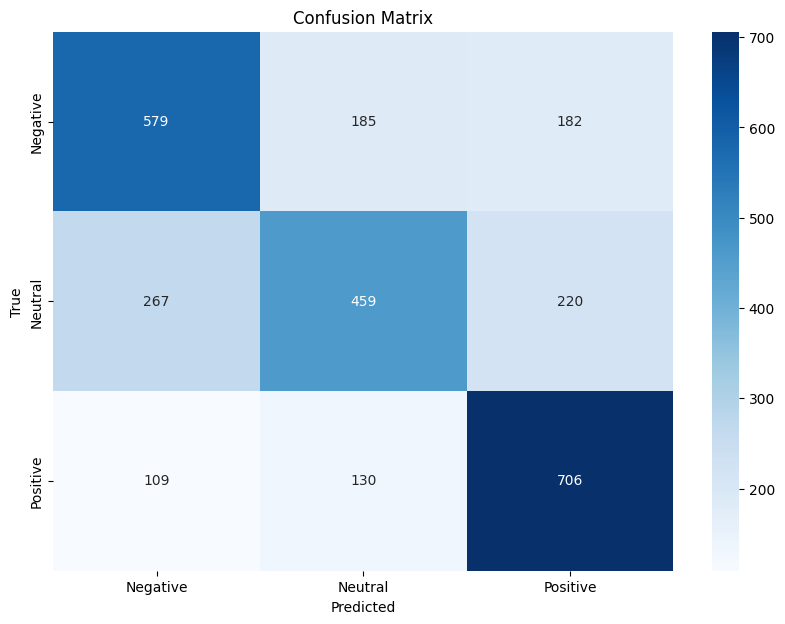


Overall Metrics:
Accuracy: 0.6147
Precision: 0.6122
Recall: 0.6147
F1 Score: 0.6102


In [245]:
def evaluate_model(y_true, y_pred, class_names):
    """
    Evaluates the performance of a classification model using various metrics and visualizations.

    Args:
    - y_true (array-like): True labels of the data.
    - y_pred (array-like): Predicted labels of the data.
    - class_names (list): List of class names in the same order as the confusion matrix.

    Returns:
    - pd.DataFrame: DataFrame containing the classification report.
    """
    # Generate and print the classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:\n", report_df)

    # Generate and display the confusion matrix as a heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print overall metrics: accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    print("\nOverall Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return report_df

# Perform predictions on the test dataset
predictions = model.predict(xtest)

# Extract predicted labels from predictions
ypred = predictions[0].argmax(axis=-1).tolist()

# Evaluate the model
report_df = evaluate_model(ytest, ypred, ["Negative", "Neutral", "Positive"])